<h1> Vidéos YouTube en Tendance </h1>

by Germain Bregeon & Emma Covili

On commence par importer les librairies qui vont nous servir tout au long du projet.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.validation import column_or_1d
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.compose import ColumnTransformer

from datetime import date

Nous allons travailler sur une base de données de Kaggle comportant différentes statistiques de vidéos qui ont été en tendance sur la plateforme YouTube entre 2009 et 2018. Nous allons essayer de prédire un nombre de like pour chaque vidéo (apprentissage supervisé) à l'aide des données à notre disposition.
On importe tout d'abord le fichier de données françaises, puis on affiche le dataframe pour appréhender la construction des données.

In [6]:
df_fr = ( pd.read_csv('archive/FRvideos.csv') )
df_fr.head()
print(df_fr.shape)

(40724, 16)


On regarde s'il existe des valeurs nulles dans notre base de données.

In [7]:
print("total null values: ", df_fr.isna().sum())

total null values:  video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                         0
views                        0
likes                        0
dislikes                     0
comment_count                0
thumbnail_link               0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description               2912
dtype: int64


Les seules valeurs nulles dans notre base sont les descriptions que nous  n'avons pas prévu d'exploiter dans ce projet, nous pouvons donc ignorer les valeur nulles dans notre cas.

On se demande si on peut trouver des doublons dans notre dataset et en faisant une recherche sur un nom de vidéo au hasard, on se rend compte qu'effectivement une même vidéo peut apparaître plusieurs fois. Cela est dû à l'attribut 'trending_date' (un des jour(s) où la vidéo était en tendance), en effet une vidéo peut rester en tendance plusieurs jours d'affilé et donc apparaître plusieurs fois.

In [8]:
df_fr[df_fr['title']=='PAPY GRENIER - METAL GEAR SOLID']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
3,WuTFI5qftCE,17.14.11,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",925222,85016,550,4303,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o..."
224,WuTFI5qftCE,17.15.11,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",1088664,90341,632,4634,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o..."
585,WuTFI5qftCE,17.16.11,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",1164164,93079,664,4773,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o..."


<h1>Attribut nombre de jours en tendance</h1>

On se rend compte que le nombre de fois qu'apparaît une vidéo dans la base correspond au nombre de jours qu'elle a passé en tendance. On décide donc de créer un nouvel attribut 'nb_trend_days' qui va nous permettre d'éliminer les doublons et de conserver le nombre de jours où la vidéo a été en tendance, information qui nous sera utile plus tard dans le projet.

In [9]:
video_ids = df_fr.video_id.tolist()

# Cette fonction compte le nombre de trending days pour une vidéo
def f(x):
    return(video_ids.count(x['video_id']))

In [10]:
# On calcule le nb_trend_days pour toutes les valeurs de notre base et on ajoute l'attribut obtenu au dataframe
df_fr = df_fr.assign(nb_trend_days = df_fr.apply(f, axis = 1))
df_fr.head()

# Cette cellule met environ 1 minute à tourner

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,nb_trend_days
0,Ro6eob0LrCY,17.14.11,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13T17:32:55.000Z,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidé...,4
1,Yo84eqYwP98,17.14.11,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...,3
2,ceqntSXE-10,17.14.11,DESSINS ANIMÉS FRANÇAIS VS RUSSES 2 - Daniil...,Daniil le Russe,23,2017-11-13T17:00:38.000Z,"cartoon""|""pokémon""|""école""|""ours""|""мультфильм",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animés français e...,3
3,WuTFI5qftCE,17.14.11,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",925222,85016,550,4303,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o...",3
4,ee6OFs8TdEg,17.14.11,QUI SAUTERA LE PLUS HAUT ? (VÉLO SKATE ROLLER ...,Aurelien Fontenoy,17,2017-11-13T16:30:03.000Z,"vélo""|""vtt""|""bmx""|""freestyle""|""bike""|""mtb""|""di...",141695,8091,72,481,https://i.ytimg.com/vi/ee6OFs8TdEg/default.jpg,False,False,False,Sauts à plus de 4 mètres de haut dans un tramp...,3


Maintenant qu'on a insérer l'attribut 'nb_trend_days', on va éliminer parmi les doublons les vidéos les moins récentes afin de conserver uniquement les données sur le dernier jour passé en tendance, celui où les nombre de vues, de likes, de dislikes et de commentaires est le plus important. Ces quatre champs étant les seuls à varier lorsqu'une vidéo est en tendance.

In [11]:
df_fr['trending_date'].dtype

dtype('O')

On observe que notre colonne 'trending_date' est un object, donc on la convertit en un format date pour que pandas puisse comparer deux données de cette colonne.

In [12]:
df_fr['trending_date'] = pd.to_datetime(df_fr['trending_date'], format='%y.%d.%m')

On va créer une nouvelle colonne dans notre dataframe 'to_trash', qu'on éliminera par la suite, qu'on va assigner à 1 si la vidéo est celle du dernier jour passé en tendance et 0 sinon.

In [13]:
# On veut maintenant éliminer les vidéos présentes plusieurs fois dans la base (1 on grade la ligne, 0 on la supprime)
def g(x):
    if(x.nb_trend_days==1):
        return(1)
    temp = df_fr[df_fr['video_id']==x['video_id']]
    if(x.trending_date == temp.trending_date.max()):
        return(1)
    else:
        return(0)

In [14]:
# On applique cette fonction à toutes les données de la base
df_fr = df_fr.assign(to_trash = df_fr.apply(g, axis = 1))
df_fr.head()

# Cette cellule met environ 1 minute à tourner

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,nb_trend_days,to_trash
0,Ro6eob0LrCY,2017-11-14,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13T17:32:55.000Z,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidé...,4,0
1,Yo84eqYwP98,2017-11-14,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...,3,0
2,ceqntSXE-10,2017-11-14,DESSINS ANIMÉS FRANÇAIS VS RUSSES 2 - Daniil...,Daniil le Russe,23,2017-11-13T17:00:38.000Z,"cartoon""|""pokémon""|""école""|""ours""|""мультфильм",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animés français e...,3,0
3,WuTFI5qftCE,2017-11-14,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",925222,85016,550,4303,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o...",3,0
4,ee6OFs8TdEg,2017-11-14,QUI SAUTERA LE PLUS HAUT ? (VÉLO SKATE ROLLER ...,Aurelien Fontenoy,17,2017-11-13T16:30:03.000Z,"vélo""|""vtt""|""bmx""|""freestyle""|""bike""|""mtb""|""di...",141695,8091,72,481,https://i.ytimg.com/vi/ee6OFs8TdEg/default.jpg,False,False,False,Sauts à plus de 4 mètres de haut dans un tramp...,3,0


On peut maintenant supprimer toutes les lignes que l'on ne veut pas conserver et qu'on a identifié grâce à l'attribut 'to_trash' ainsi que cette dernière colonne dont on n'a plus besoin.

In [15]:
df_fr = df_fr[df_fr['to_trash']==1]
df_fr.drop('to_trash', axis = 1, inplace=True)

<h1>Analyse statistique et graphes pour comprendre la distribution des données et les liens de corrélations entre les différents attributs</h1>

On utilise la méthode describe pour obtenir des informations statistiques sur les données.

In [16]:
df_fr.filter(['views','likes','dislikes','comment_count','nb_trend_days']).describe()

,views,likes,dislikes,comment_count,nb_trend_days
count,3.058100e+04,3.058100e+04,3.058100e+04,3.058100e+04,30581.000000
mean,3.458344e+05,1.207631e+04,5.888141e+02,1.322356e+03,1.331677
std,1.539143e+06,7.022785e+04,8.948487e+03,1.083382e+04,0.651878
min,2.840000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,1.197500e+04,2.500000e+02,1.300000e+01,4.100000e+01,1.000000
50%,5.351300e+04,1.266000e+03,5.800000e+01,1.740000e+02,1.000000
75%,2.160520e+05,4.979000e+03,2.460000e+02,6.110000e+02,1.000000
max,1.009116e+08,4.750254e+06,1.353661e+06,1.040912e+06,6.000000


On se demande s'il y a un lien évident entre nombre de vues et nombre de likes

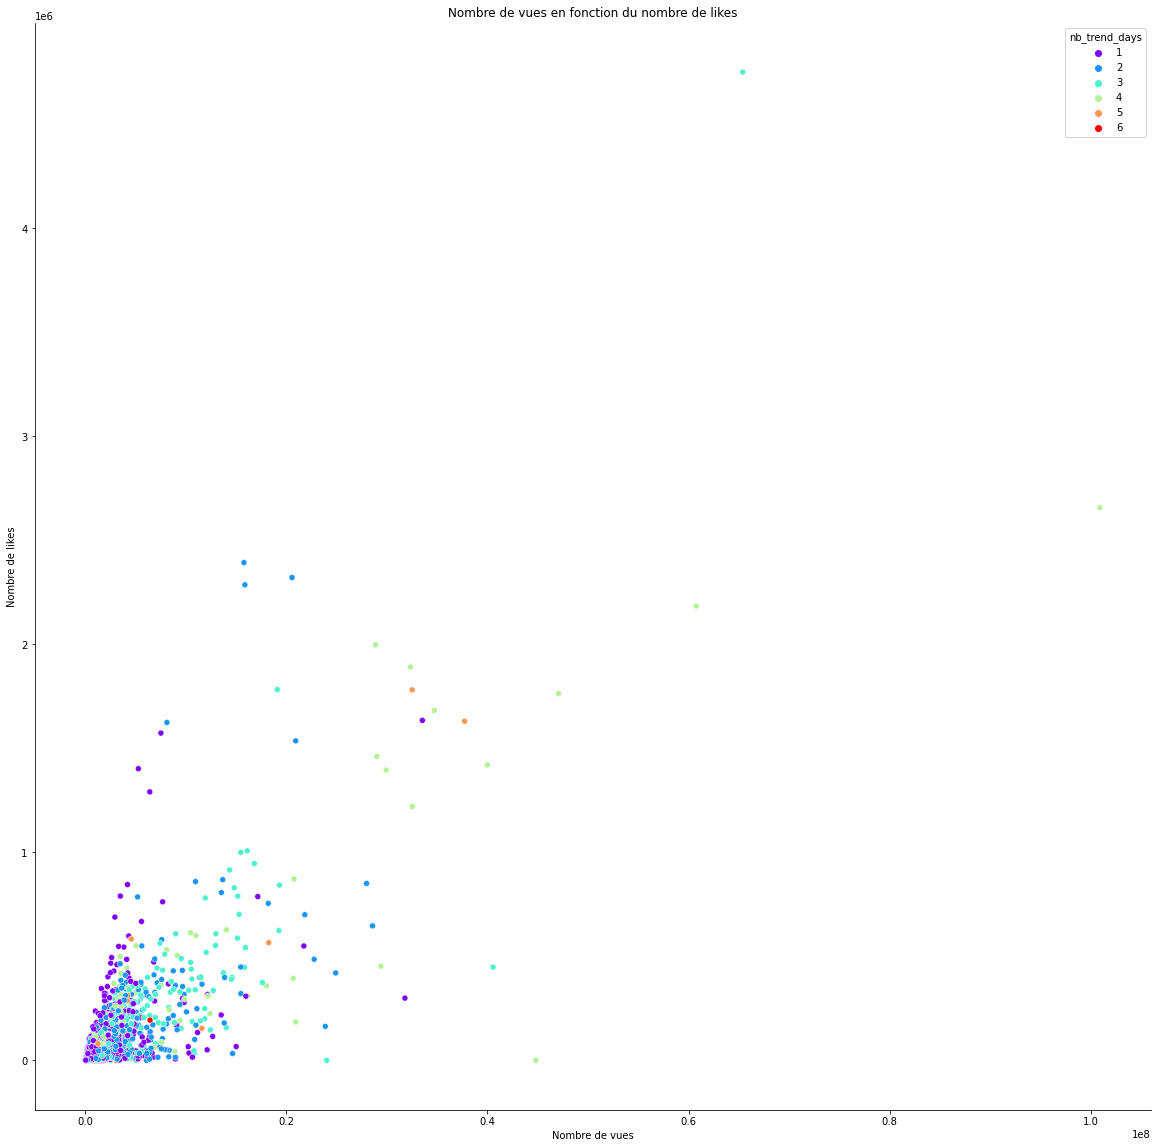

In [13]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=df_fr, x="views", y="likes", hue="nb_trend_days", palette="rainbow")

plt.title("Nombre de vues en fonction du nombre de likes")
plt.xlabel("Nombre de vues")
plt.ylabel("Nombre de likes")

sns.despine()
plt.show()

On se rend compte que 1 point est très isolé en haut du graphe. Il fausse les données et se retrouve avec un nombre très élevé de likes par rapport aux autres. On regarde à quelle vidéo correspond cette valeur.

In [14]:
df_fr[df_fr["likes"]>3e+06]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,nb_trend_days
35902,7C2z4GqqS5E,2018-05-21,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",65396157,4750254,141966,1040912,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,3


On remarque que ce n'est pas une vidéo française mais une vidéo de musique coréenne donc on se permet de la supprimer pour avoir une meilleure qualité de nos données.

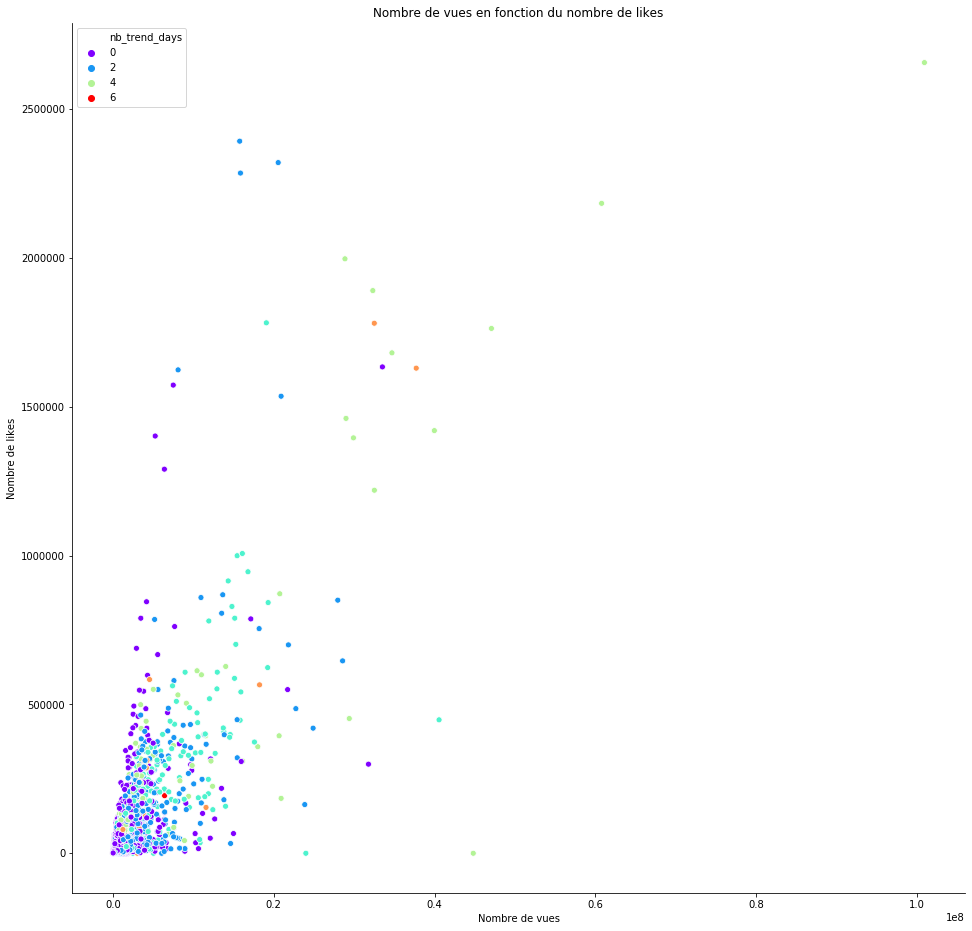

In [17]:
df_fr = df_fr[df_fr["likes"]<3e+06]

plt.figure(figsize=(16,16))
sns.scatterplot(data=df_fr, x="views", y="likes", hue="nb_trend_days", palette="rainbow")

plt.title("Nombre de vues en fonction du nombre de likes")
plt.xlabel("Nombre de vues")
plt.ylabel("Nombre de likes")

sns.despine()
plt.show()

On fait de même pour les vidéos avec un nombre de vues très élevé.

In [18]:
df_fr = df_fr[df_fr["views"]<0.6e+08]

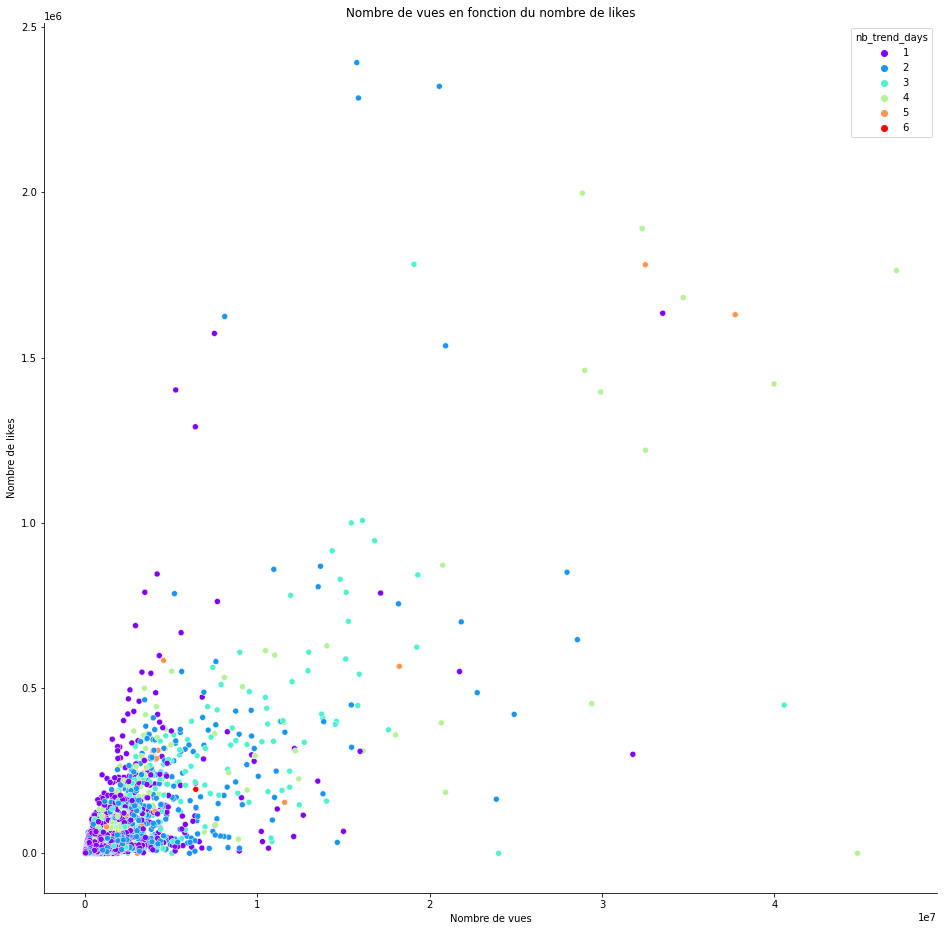

In [17]:
plt.figure(figsize=(16,16))

sns.scatterplot(data=df_fr, x='views', y='likes', hue='nb_trend_days', palette='rainbow')
plt.title("Nombre de vues en fonction du nombre de likes")
plt.xlabel("Nombre de vues")
plt.ylabel("Nombre de likes")

sns.despine()
plt.show()

On se rend compte qu'il y a  une tendance entre les vues et le nombre de likes mais qu'elle reste très faible.

On affiche une heatmap qui représente la corrélation entre différents attributs de notre base de données. On cherche à savoir si certains attributs sont plus corrélés que d'autres au nombre de likes.

<AxesSubplot:>

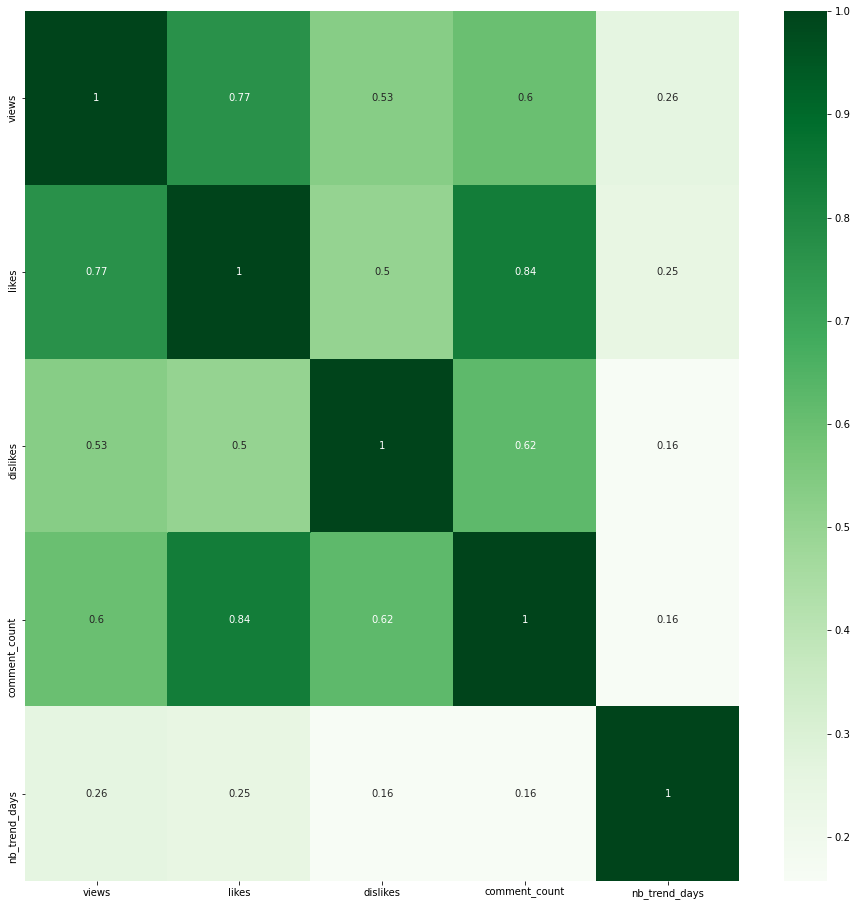

In [18]:
plt.figure(figsize=(16,16))
sns.heatmap(df_fr[['views','likes','dislikes','comment_count','nb_trend_days']].corr(), annot=True, cmap='Greens')

On observe que le nombre de likes est corrélé à 77% au nombre de vues, et que le nombre de likes est corrélé à 84% au nombre de commentaire. On constate également, dans une moindre mesure, que le temps qu'une vidéo a passé en tendance influe sur le nombre de vues et le nombres de likes.

On va mettre se phénomène encore plus en évidence.

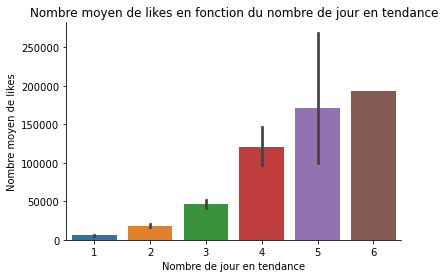

In [19]:
sns.barplot(data=df_fr, x='nb_trend_days', y='likes', estimator=np.mean)

plt.title("Nombre moyen de likes en fonction du nombre de jour en tendance")
plt.xlabel("Nombre de jour en tendance")
plt.ylabel("Nombre moyen de likes")

sns.despine()
plt.show()

On observe donc logiquement que plus une vidéo est en tendance longtemps, plus elle a de likes.

<h2>Première piste - création des étiquettes pour les clusters</h2>

On cherche à prédire un ordre de grandeur du nombre de like d'une vidéo en fonction de ces différentes caracatéristiques, qu'on ajoutera au fur et à mesure pour affiner l'estimation. Pour cela, on cherche à faire des clusters de vidéos mises en avant par l'algorithme de Youtube.

On cherche les différents quantile associé à la distribution des likes pour toutes les vidéos. L'intervalle entre deux de ces quantiles correspondra à un de nos clusters. Nous n'aurons ainsi que des clusters équilibrés dans notre base.

On fixe le nombre de cluster à 6, et on observe les intervalles qui en découle.

In [20]:
nb_cluster = 8
quant = np.quantile(df_fr[['likes']],np.linspace(0,1,nb_cluster))
print(quant)

[0.00000000e+00 1.04000000e+02 3.18000000e+02 8.17000000e+02
 1.86800000e+03 4.02871429e+03 1.18878571e+04 2.39259500e+06]


On assigne un cluster à chaque entrée de la base de donnée.

In [21]:
# Fonction qui attribut une vidéo à son identifiant de cluster
def labelize(x,quant):
    for i in range(len(quant)):
        if(x<quant[i]):
            break
    return(int(i))

On crée un nouvel attribut qui va correspondre à l'étiquette du cluster de chaque entrée de notre jeu de données pour ensuite pouvoir faire du clustering sur ces étiquettes.

In [22]:
c=[labelize(x, quant) for x in df_fr['likes']]
df_fr.insert(len(df_fr.columns),'label',c)

In [23]:
df_fr["label"].value_counts().to_frame().reset_index()

,index,label
0,3,4375
1,7,4369
2,5,4369
3,6,4368
4,4,4368
5,2,4366
6,1,4363


On constate que les différents clusters crées sont de tailles équilibrés. On va maintenant les afficher.

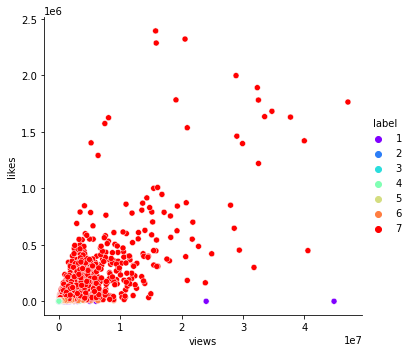

In [24]:
sns.relplot(data=df_fr, x='views', y='likes', hue='label', palette='rainbow')

sns.despine()
plt.show()

On ne voit pas grand chose sur le graphe précedent, à part la dernière classe. On décide d'afficher chaque cluster séparément.

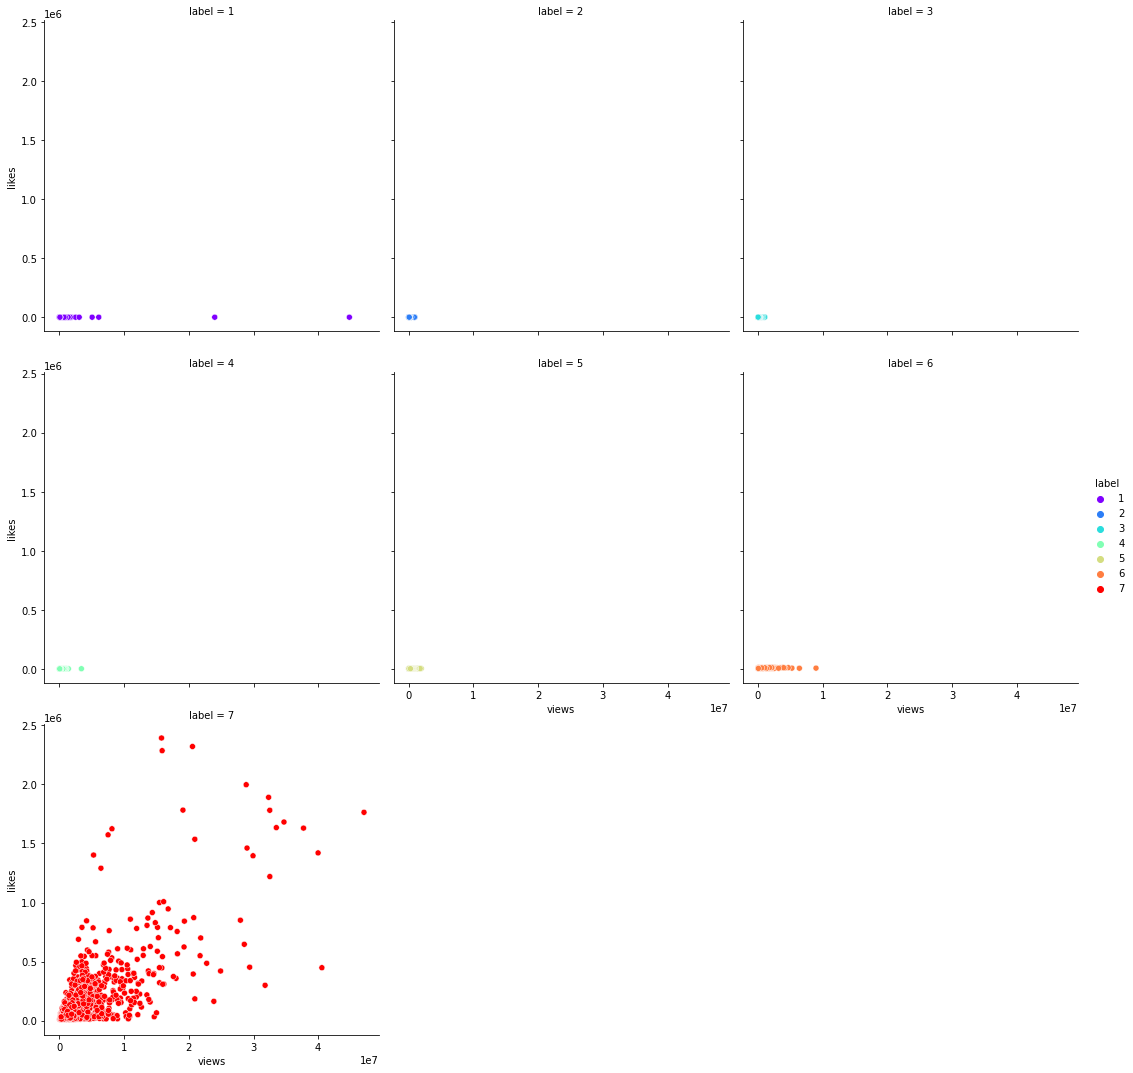

In [25]:
sns.relplot(data=df_fr, x='views', y='likes', hue='label', col='label', col_wrap=3, palette='rainbow')

sns.despine()
plt.show()

Les graphes pour les premiers clusters ne sont pas très expressifs, en effet celui de la dernière classe a une bien plus grande échelle. On décide d'afficher sur un graphe seul les données d'un même cluster pour avoir une sorte de zoom et bien voir les données.

Nombre de likes en fonction du nombre de vues pour les vidéos de la classe 1


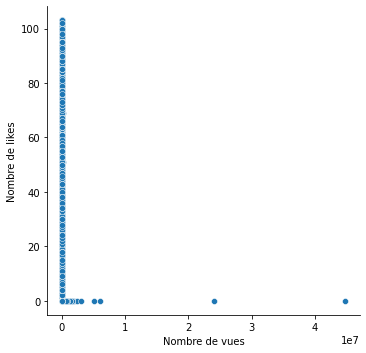

Nombre de likes en fonction du nombre de vues pour les vidéos de la classe 2


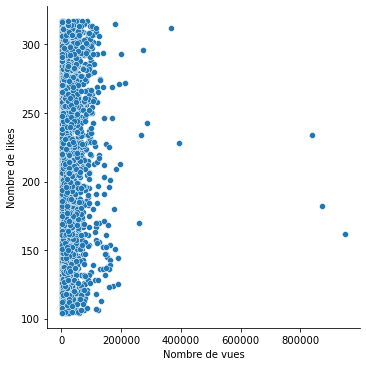

Nombre de likes en fonction du nombre de vues pour les vidéos de la classe 3


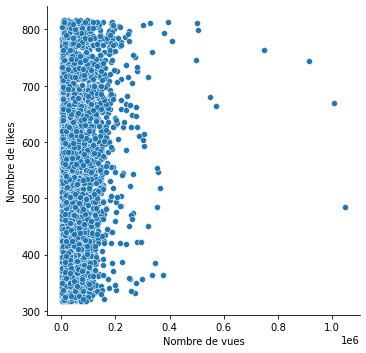

Nombre de likes en fonction du nombre de vues pour les vidéos de la classe 4


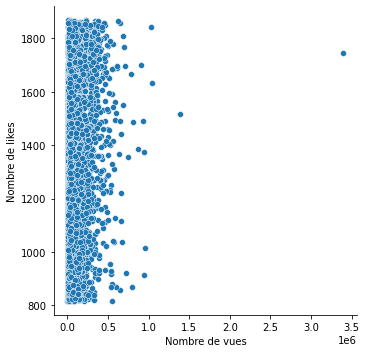

Nombre de likes en fonction du nombre de vues pour les vidéos de la classe 5


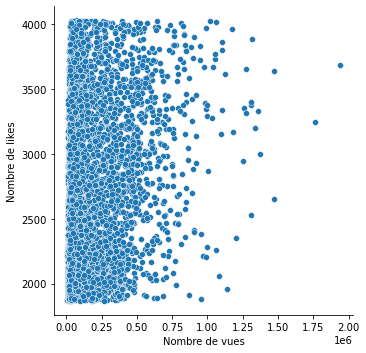

Nombre de likes en fonction du nombre de vues pour les vidéos de la classe 6


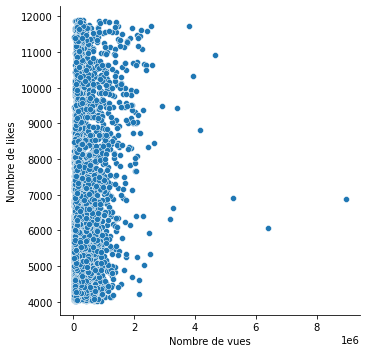

Nombre de likes en fonction du nombre de vues pour les vidéos de la classe 7


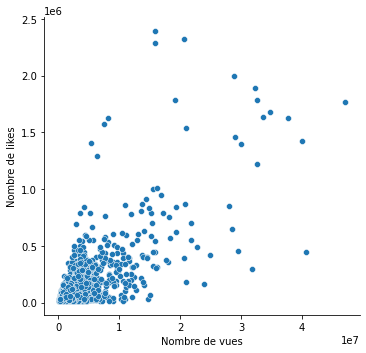

In [26]:
# Fonction qui plot les données cluster par cluster
def plot_cluster(dt, label):
    df_label = df_fr[df_fr['label']==label]
    
    print("Nombre de likes en fonction du nombre de vues pour les vidéos de la classe", i)
    sns.relplot(data=df_label, x='views', y='likes')

    plt.xlabel("Nombre de vues")
    plt.ylabel("Nombre de likes")

    plt.show()
    
for i in range(1,nb_cluster):
    plot_cluster(df_fr, i)

On voit bien mieux les seuils associés aux quantiles que sur les précédents graphes. On voit bien aussi qu'il y a beaucoup de données et qu'elles sont très ramassées, ce qu'on ne voyait pas trop précedemment car le graphe des vidéos de la dernière classe a une bien plus grande échelle. On se dit que le clustering va être difficile puisque les différents clusters se superposent beaucoup.

On essaye notre clustering.

In [27]:
X = df_fr.filter(['views','comment_count','dislikes','nb_trend_days']).values
y = df_fr.filter(['label']).values
y = np.reshape(y,(y.shape[0]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=36)

In [28]:
pipeline = Pipeline ([('scaler', StandardScaler()),('clf', LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=5000))])
params = [{'clf__C': [1, 10, 100, 500, 1000, 1500],
          'scaler': [StandardScaler(), 'passthrough']}]

rskf = StratifiedKFold(n_splits=10, shuffle=False)
cv = GridSearchCV(pipeline, params, cv = rskf, scoring = 'accuracy', n_jobs = -1)

cv.fit(X_train, y_train)

print(f'Best accuracy -score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')

preds = cv.predict(X_test)
print(f'Scores: {classification_report(y_test, preds)}\n')
print(f'accuracy-score: {accuracy_score(y_test, preds):.3f}')

Best accuracy -score: 0.437

Best parameter set: {'clf__C': 100, 'scaler': StandardScaler()}

Scores:               precision    recall  f1-score   support

           1       0.43      0.76      0.55      1296
           2       0.33      0.24      0.28      1340
           3       0.31      0.30      0.30      1271
           4       0.31      0.27      0.29      1323
           5       0.38      0.31      0.34      1326
           6       0.44      0.43      0.43      1320
           7       0.80      0.71      0.76      1298

    accuracy                           0.43      9174
   macro avg       0.43      0.43      0.42      9174
weighted avg       0.43      0.43      0.42      9174


accuracy-score: 0.430


On observe bien que les résultas ne sont pas excellents.
<br>En effet, sur les graphes précédents on a pu constater que les clusters étaient souvent supperposés, ce qui peut expliquer la performance plutôt mauvaise de notre régression logistique. On décide de drop la colonne des labels et de changer de méthode. 

In [29]:
df_fr.drop('label', axis=1, inplace=True)

<h1>Deuxième piste</h1>

On utilise la régression ridge qui va nous permettre non pas de prédire un cluster pour chaque vidéo, mais un nombre de like précis, et on estime la précision de notre régression grâce à un score R2.

In [30]:
X = df_fr.filter(['views','comment_count','dislikes','nb_trend_days']).values
y = df_fr.filter(['likes']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=36)

In [31]:
pipeline = Pipeline ([('scaler', StandardScaler()),('clf',Ridge())])

params = [{'scaler': [StandardScaler(), 'passthrough'],
         'clf__alpha': [1.0, 3.0, 5.0, 7.0]}]

rskf = StratifiedKFold(n_splits=10, shuffle=False)
mc = GridSearchCV(pipeline, params,scoring = 'r2', cv = rskf, n_jobs = -1)

mc.fit(X_train, y_train)

print(f'Best parameter set: {mc.best_params_}\n')

preds = mc.predict(X_test)
print(f'R2-score: {r2_score(y_test, preds):.5f}')

/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best parameter set: {'clf__alpha': 7.0, 'scaler': StandardScaler()}

R2-score: 0.86087


On obtient un résultat bien plus probant.

<h2>Rajout des catégories dans les données que l'on utilise</h2>

On va maintenant exploiter les catégorie des vidéos. On cherche à savoir si certaines catégories sur la plateforme YouTube correspondent à des vidéos qui ont en moyenne plus de likes que les autres.

On commence par lire le fichier 'json' qui liste toutes les différentes catégories que YouTube utilise. En effet, il n'y a que les identifiants des catégories dans le dataframe et nous voulons, pour des résultats plus parlant, retrouver les noms des catégories contenus dans le fichier 'json' (fourni avec le dataset).

In [19]:
# On récupère dans un dictionnaire les catégories associées à leur id
import json

with open('archive/FR_category_id.json', 'r') as f:
    json_dict = json.load(f)["items"]

c_dict={}
for c in json_dict:
    c_dict[int(c["id"])] = c["snippet"]["title"]

# Pour chaque catégorie, on calcule le nombre moyen de likes pour une vidéo de cette même catégorie
mean_cat=[]
for item in c_dict.items():
    mean_cat.append(np.mean(df_fr[df_fr["category_id"]==item[0]]["likes"]))

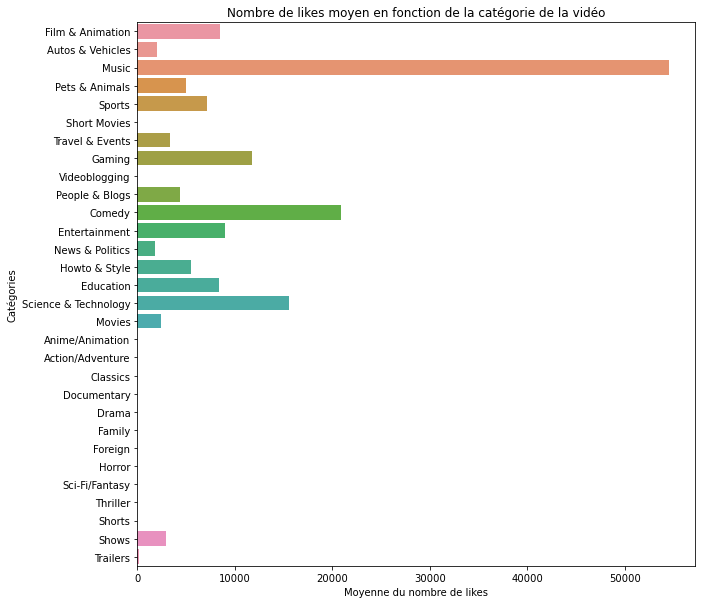

In [33]:
plt.figure(figsize=(10,10))

sns.barplot(x=mean_cat, y=list(c_dict.values()))

plt.title("Nombre de likes moyen en fonction de la catégorie de la vidéo")
plt.xlabel("Moyenne du nombre de likes")
plt.ylabel("Catégories")

plt.show()

On observe bien que certaines catégories de vidéo (comme la musique) ont plus de likes sur leurs vidéos.

On rajoute l'attribut 'category_id' dans notre apprentissage et on observe si notre score s'améliore ou non.

In [34]:
X = df_fr.filter(['views','dislikes','comment_count','category_id','nb_trend_days']).values
y = df_fr.filter(['likes']).values
y = np.reshape(y,(y.shape[0]))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=36)

In [35]:
pipeline = Pipeline ([('scaler', StandardScaler()),('clf',Ridge())])

params = [{'scaler': [StandardScaler(), 'passthrough'],
         'clf__alpha': [1.0, 3.0, 5.0, 7.0]}]

rskf = StratifiedKFold(n_splits=10, shuffle=False)
mc = GridSearchCV(pipeline, params, scoring = 'r2', cv = rskf, n_jobs = -1)

mc.fit(X_train, y_train)

print(f'Best parameter set: {mc.best_params_}\n')

preds = mc.predict(X_test)
print(f'R2-score: {r2_score(y_test, preds):.5f}')

/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best parameter set: {'clf__alpha': 7.0, 'scaler': StandardScaler()}

R2-score: 0.86113


Le R2_score a légèrement augmenté.

<h2>On utilise les dates</h2>
<h3>A - On commence par les années</h3>
<br>
On décide maintenant d'exploiter les dates de publication des vidéos. On va le faire en plusieurs étapes. La première information que nous allons exploiter est l'année de publication des vidéos de la base.

On convertit l'attribut 'publish_time' en datetime pour pouvoir l'exploiter plus facilement.

In [20]:
df_fr['publish_time'] = pd.to_datetime(df_fr['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

On crée un attribut qui correspond à l'année de publication de la vidéo.

In [21]:
df_fr['publish_year'] = df_fr['publish_time'].apply(lambda x: int(x.strftime('%Y')))

On fait un graphe qui compare le nombre moyen de likes d'une vidéo en fonction de son année de publication.

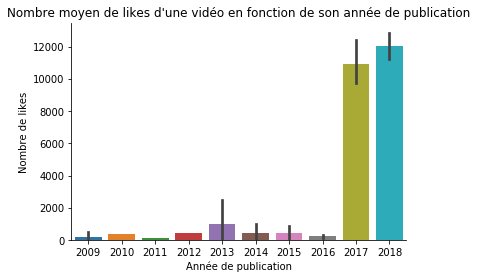

In [22]:
sns.barplot(data=df_fr, x='publish_year', y='likes', estimator=np.mean, order=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018])

plt.title("Nombre moyen de likes d'une vidéo en fonction de son année de publication")
plt.xlabel("Année de publication")
plt.ylabel("Nombre de likes")

sns.despine()
plt.show()

On observe sans grande surprise que 2017 et 2018 concentrent beaucoup plus de likes que les autres années. En effet l'outil tendance de YouTube a été créé en 2017, ce qui explique le fait qu'il y ait très peu de données pour les années avant 2017.

<h3>B - On rajoute les mois</h3>

On va faire la même chose pour les mois de publication.

In [23]:
df_fr['publish_month'] = df_fr['publish_time'].apply(lambda x: int(x.strftime('%m')))

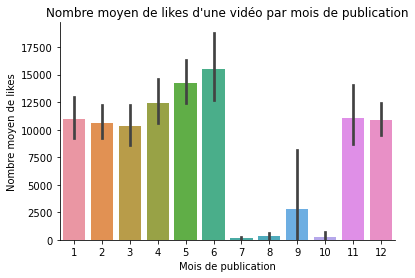

In [40]:
sns.barplot(data=df_fr, x='publish_month', y='likes', estimator=np.mean, order=[1,2,3,4,5,6,7,8,9,10,11,12])

plt.title("Nombre moyen de likes d'une vidéo par mois de publication")
plt.xlabel("Mois de publication")
plt.ylabel("Nombre moyen de likes")

sns.despine()
plt.show()

On remarque que certains mois de publication (les mois d'étés et du début de l'automne) correspondent à un très faible niveau de likes.

On adapte notre attribut 'publish_month' pour en faire 2 attributs qui représenteront l'aspect cyclique des mois d'une année (janvier est très proche de décembre et février ce qui ne serait pas mis en évidence avec seulement des entiers).

In [24]:
months_in_year = 12
df_fr['sin_publish_month'] = np.sin(2*np.pi*df_fr.publish_month/months_in_year)
df_fr['cos_publish_month'] = np.cos(2*np.pi*df_fr.publish_month/months_in_year)
df_fr.drop('publish_month', axis=1, inplace=True)

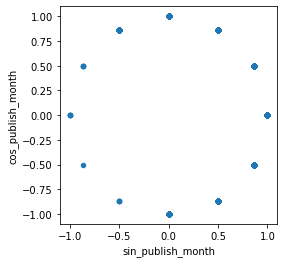

In [42]:
df_fr.sample(15000).plot.scatter('sin_publish_month','cos_publish_month').set_aspect('equal')

On voit bien que chaque mois est associé à un des points du cercle.

<h3>C - On rajoute les jours</h3>

On va faire la même chose pour les jours de publication.

In [25]:
df_fr['publish_day'] = df_fr['publish_time'].apply(lambda x: x.strftime('%A'))

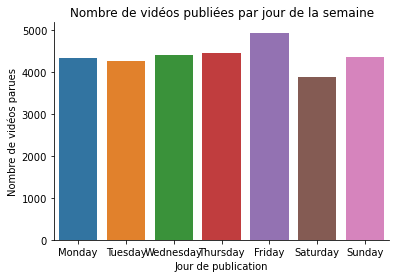

In [44]:
publication_jour = df_fr["publish_day"].value_counts().to_frame().reset_index()

sns.barplot(data=publication_jour, x='index', y='publish_day', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.title("Nombre de vidéos publiées par jour de la semaine")
plt.xlabel("Jour de publication")
plt.ylabel("Nombre de vidéos parues")

sns.despine()
plt.show()

On observe qu'il y a un peu plus de vidéos publiées le vendredi et un peu moins le samedi.

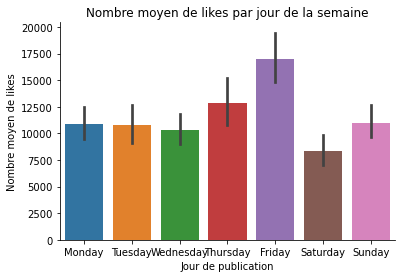

In [45]:
sns.barplot(data=df_fr, x='publish_day', y='likes', estimator=np.mean, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.title("Nombre moyen de likes par jour de la semaine")
plt.xlabel("Jour de publication")
plt.ylabel("Nombre moyen de likes")

sns.despine()
plt.show()

Mécaniquement il y a plus de likes le vendredi et un peu moins le samedi.

Comme pour les mois on représente les données de manière cyclique.

In [26]:
df_fr['publish_day'] = df_fr['publish_time'].apply(lambda x: int(x.strftime('%w')))

In [27]:
days_in_week = 7
df_fr['sin_publish_day'] = np.sin(2*np.pi*df_fr.publish_day/days_in_week)
df_fr['cos_publish_day'] = np.cos(2*np.pi*df_fr.publish_day/days_in_week)
df_fr.drop('publish_day', axis=1, inplace=True)

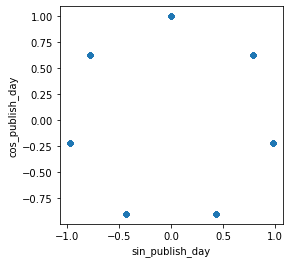

In [48]:
df_fr.sample(1500).plot.scatter('sin_publish_day','cos_publish_day').set_aspect('equal')

<h3>D - On rajoute les heures de publication</h3>

On va faire la même chose pour les heures de publication.

In [28]:
df_fr['publish_hour'] = df_fr['publish_time'].apply(lambda x: int(x.strftime('%H')))

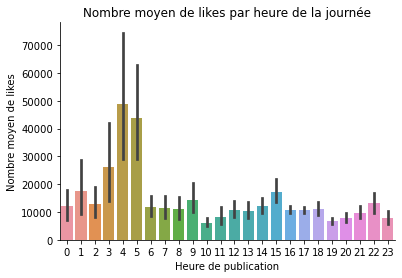

In [50]:
sns.barplot(data=df_fr, x='publish_hour', y='likes', estimator=np.mean, order=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

plt.title("Nombre moyen de likes par heure de la journée")
plt.xlabel("Heure de publication")
plt.ylabel("Nombre moyen de likes")


sns.despine()
plt.show()

On observe un pic étrange entre 3 et 6 heures du matin, on peut penser que cela est dû à la publication de vidéos étrangères, notamment de musique coréenne car le décalage horaire correspond, qu'on a déjà remarqué plus tôt que les vidéos de musique géénérait beaucoup de likes et qu'une des vidéos les plus likées du dataset est une vidéo de k-pop.

Encore une fois on les représente de manière cyclique.

In [29]:
hours_in_day = 24
df_fr['sin_publish_hour'] = np.sin(2*np.pi*df_fr.publish_hour/hours_in_day)
df_fr['cos_publish_hour'] = np.cos(2*np.pi*df_fr.publish_hour/hours_in_day)
df_fr.drop('publish_hour', axis=1, inplace=True)

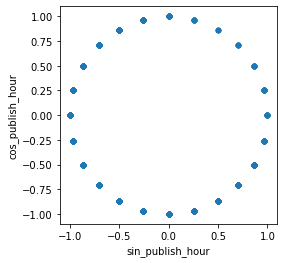

In [52]:
df_fr.sample(1500).plot.scatter('sin_publish_hour','cos_publish_hour').set_aspect('equal')

On effectue un nouvel apprentissage avec toutes les données temporelles que nous venons de rajouter dans notre dataset.

In [53]:
X = df_fr.filter(['views','dislikes','comment_count','category_id','nb_trend_days','publish_year','sin_publish_month','cos_publish_month','sin_publish_day','cos_publish_day','sin_publish_hour','cos_publish_hour']).values
y = df_fr.filter(['likes']).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=36)

In [54]:
pipeline = Pipeline ([('scaler', StandardScaler()),('clf',Ridge())])

params = [{'scaler': [StandardScaler(), 'passthrough'],
         'clf__alpha': [1.0, 3.0, 5.0, 7.0]}]

rskf = StratifiedKFold(n_splits=10, shuffle=False)
mc = GridSearchCV(pipeline, params, scoring = 'r2', cv = rskf, n_jobs = -1)

mc.fit(X_train, y_train)

print(f'Best parameter set: {mc.best_params_}\n')

preds = mc.predict(X_test)
print(f'R2-score: {r2_score(y_test, preds):.5f}')

/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best parameter set: {'clf__alpha': 7.0, 'scaler': StandardScaler()}

R2-score: 0.86212


On observe encore une fois que le score R2 a encore augmenté.

<h2> Conversion des colonnes booléennes en entiers</h2>
<br>On convertit les colonnes contenant des booléens en entier et on observe ce que ça change sur notre régression.

In [30]:
df_fr["comments_disabled"]=(df_fr["comments_disabled"]=="True").astype(int)
df_fr["ratings_disabled"]=(df_fr["ratings_disabled"]=="True").astype(int)
df_fr["video_error_or_removed"]=(df_fr["video_error_or_removed"]=="True").astype(int)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [56]:
X = df_fr.filter(['views','dislikes','comment_count','category_id','nb_trend_days','publish_year','sin_publish_month','cos_publish_month','sin_publish_day','cos_publish_day','sin_publish_hour','cos_publish_hour','comments_disabled','ratings_disabled','video_error_or_removed']).values
y = df_fr.filter(['likes']).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=36)

In [57]:
pipeline = Pipeline ([('scaler', StandardScaler()),('clf',Ridge())])

params = [{'scaler': [StandardScaler(), 'passthrough'],
         'clf__alpha': [1.0, 3.0, 5.0, 7.0]}]

rskf = StratifiedKFold(n_splits=10, shuffle=False)
mc = GridSearchCV(pipeline, params, scoring = 'r2', cv = rskf, n_jobs = -1)

mc.fit(X_train, y_train)

print(f'Best parameter set: {mc.best_params_}\n')

preds = mc.predict(X_test)
print(f'R2-score: {r2_score(y_test, preds):.5f}')

/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best parameter set: {'clf__alpha': 7.0, 'scaler': StandardScaler()}

R2-score: 0.86212


Le R2 score n'a pas augmenté, ce qui paraît logique, très peu de vidéos ont les commentaires ou les likes désactivés.

<h2>On utilise le nom des différentes chaînes</h2>
<br>
On fait un one hot encoding sur le nom des différentes chaînes afin de pouvoir utiliser ces données. On crée donc deux pipelines, un pour les données numériques (tout ce qu'on a fait jusqu'à maintenant) et un  pour les données catégorielles (le nom de chaque chaîne).

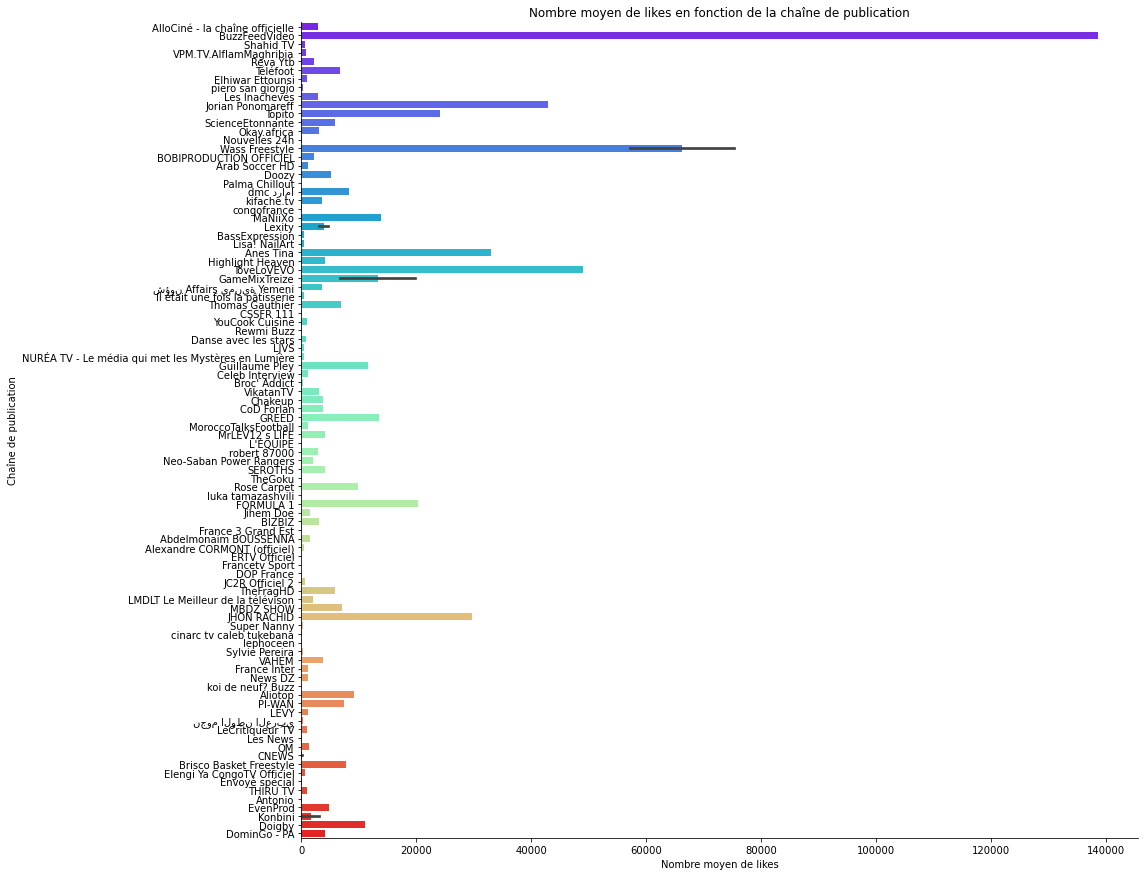

In [58]:
plt.figure(figsize=(15,15))

sns.barplot(data=df_fr.sample(100), x="likes", y="channel_title", estimator=np.mean ,palette="rainbow")

plt.title("Nombre moyen de likes en fonction de la chaîne de publication")
plt.xlabel("Nombre moyen de likes")
plt.ylabel("Chaîne de publication")

sns.despine()
plt.show()

# Des Warnings peuvent apparaître, ils sont dus au fait que Python ne supporte pas certain des caractères utilisés, notamment les hanja coréens
# De plus, seules 100 vidéos sont sélectionnées car le graphe devient illisible autrement

In [59]:
X = df_fr.drop('likes', axis = 1)
y = df_fr.likes
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=36)

In [60]:
# Pipeline de preprocessing sur les données numériques (identique à ce qu'on a fait précédement)
numerical_features = ['views','dislikes','comment_count','category_id','nb_trend_days','publish_year','sin_publish_month','cos_publish_month','sin_publish_day','cos_publish_day','sin_publish_hour','cos_publish_hour','comments_disabled','ratings_disabled','video_error_or_removed']

numerical_preprocessing = Pipeline([('scaler', StandardScaler())])

# Pipeline de preprocessing sur les données catégorielles (le nom des chaînes des vidéos en tendance)
categorical_features = ['channel_title']

categorical_preprocessing = Pipeline([('encoding', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_preprocessing, categorical_features),
        ('numericals', numerical_preprocessing, numerical_features)
    ],
    remainder = 'drop'
)

# On peut maintenant créer notre pipeline avec le preprocessing et notre classifieur

pipeline = Pipeline([('preprocessor', preprocessor), ('clf', Ridge())])

params = [{'preprocessor__numericals__scaler': [StandardScaler(), 'passthrough'],
         'clf__alpha': [0.1, 0.5, 1.0, 2.0]}]

# On peut enfin lancer les différents fits qui vont déterminer les meilleures variables de notre problème

rskf = StratifiedKFold(n_splits=10, shuffle=False)
mc = GridSearchCV(pipeline, params, scoring = 'r2', cv = rskf, n_jobs = -1)

mc.fit(X_train, y_train)

print(f'Best parameter set: {mc.best_params_}\n')

preds = mc.predict(X_test)
print(f'R2-score: {r2_score(y_test, preds):.5f}')

/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameter set: {'clf__alpha': 0.5, 'preprocessor__numericals__scaler': StandardScaler()}

R2-score: 0.90198


On voit que le score a beaucoup augmenté ici, cela peut s'expliquer par le fait que naturellement certaines chaînes YouTube ont eu un public plus grand (plus d'abonnés), plus de vidéos en tendance et donc plus de likes.

<h2>On rajoute les tags</h2>
<br>
On va essayer de ne retenir qu'un seul tag par vidéo pour ensuite faire un one hot encoding sur les différents tags que l'on a retenu.

In [31]:
df_fr['tags']

6        fantome"|"esprits"|"spiritisme"|"hanté"|"ouija...
7        salut les terriens"|"squeezie"|"jeux videos"|"...
23       robot"|"demain tous crétins"|"intelligence art...
28       squeezie doublage"|"squeezie batman"|"squeezie...
29       INTHEPANDA"|"INTHEPANDA CRITIQUE"|"INTHEPANDA ...
                               ...                        
40719    تنظيم كأس العالم 2026|"كأس العالم 2026"|"المغر...
40720    الباكالوريا في المغرب|"صحاب الباك"|"صحاب الباك...
40721    RushManga|"rush manga"|"anime a voir"|"UN ANIM...
40722    Նռան հատիկ|"Սերիա 192"|"Pomegranate seed"|"Nra...
40723                    ramadan2018|"koorgui"|"Mandoumbé"
Name: tags, Length: 30578, dtype: object

In [32]:
# On crée un dictionnaire qui va compter le nombre de vidéos différentes dans laquelle apparaît un tag donné. 
compt_occu = {}

In [33]:
# On commence par transformer les tags en liste de string
def transform_list(x):
    L=[]
    t = x.tags
    i=0
    check=True 
    while check:
        if not('|' in t):
            L.append(t.upper())
            check=False
        else:
            i=t.index('|')+2
            L.append(t[:i-3].upper())
            t=t[i:]
    #On remplit le dictionnaire qu'on a crée au-dessus avec les différents tags que l'on rencontre
    for i in range(len(L)):
        if L[i] in compt_occu.keys():
            compt_occu[L[i]]+=1
        else:
            compt_occu[L[i]]=1
    return(L)

In [34]:
# On applique cette transformation sur toute la colonne 'tags'
df_fr = df_fr.assign(tags = df_fr.apply(transform_list, axis = 1))

In [35]:
# On ne garde que un des tags de la colonne (celui qui a le plus d'occurence dans notre dictionnaire qui compte les occurences de tous les tags de notre base de données)
def garde_max(x):
    L=x.tags
    L_occur=[compt_occu[i] for i in L]
    return(L[L_occur.index(max(L_occur))])


In [36]:
# De même, on applique cette fonction pour redéfinir les tags de notre base de données
df_fr = df_fr.assign(tags = df_fr.apply(garde_max, axis = 1))
df_fr.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,video_error_or_removed,description,nb_trend_days,publish_year,sin_publish_month,cos_publish_month,sin_publish_day,cos_publish_day,sin_publish_hour,cos_publish_hour
6,nduL7G_gJoY,2017-11-14,De retour dans le Manoir hanté avec le Grand J...,silent jill,24,2017-11-12 19:00:08,MAISON,187654,9286,1381,...,0,"Bonsoir à tous, \nJe tenais beaucoup à retourn...",1,2017,-0.5,0.866025,0.000000,1.000000,-9.659258e-01,2.588190e-01
7,QmpWE_SODZA,2017-11-14,"T'es qui toi ? Squeezie, le youtubeur aux 4 mi...",Salut les terriens !,24,2017-11-13 17:30:01,INTERVIEW,91051,1674,1903,...,0,"Dans Salut Les Terriens, Thierry Ardisson, reç...",1,2017,-0.5,0.866025,0.781831,0.623490,-9.659258e-01,-2.588190e-01
23,Wbbj4oZ-Wmo,2017-11-14,[Zap Télé] LA FIN DE L'INTELLIGENCE (13/11/17),Zap Télé,24,2017-11-13 11:08:25,ZAP,72519,689,23,...,0,"Sophia fascine les journalistes, Jérémy Ferrar...",1,2017,-0.5,0.866025,0.781831,0.623490,2.588190e-01,-9.659258e-01
28,exMNBvwCfRY,2017-11-14,LES PIRES DOUBLAGES FRANÇAIS,SQUEEZIE,23,2017-11-10 18:25:25,SQUEEZIE DOUBLAGE,3641421,218587,5809,...,0,"Quand la voix ne colle pas au perso, que la tr...",1,2017,-0.5,0.866025,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16
29,8YEGqrtsxBc,2017-11-14,6 CRITIQUES OCT/NOV (Thor 3 / Carbone / Au Rev...,INTHEPANDA,1,2017-11-12 12:59:45,NEKFEU,102804,6306,179,...,0,S'abonner permet d'être coolos : http://bit.ly...,1,2017,-0.5,0.866025,0.000000,1.000000,1.224647e-16,-1.000000e+00


/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/emmacovili/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/emmacovili/opt/anaconda3/lib/python3.8

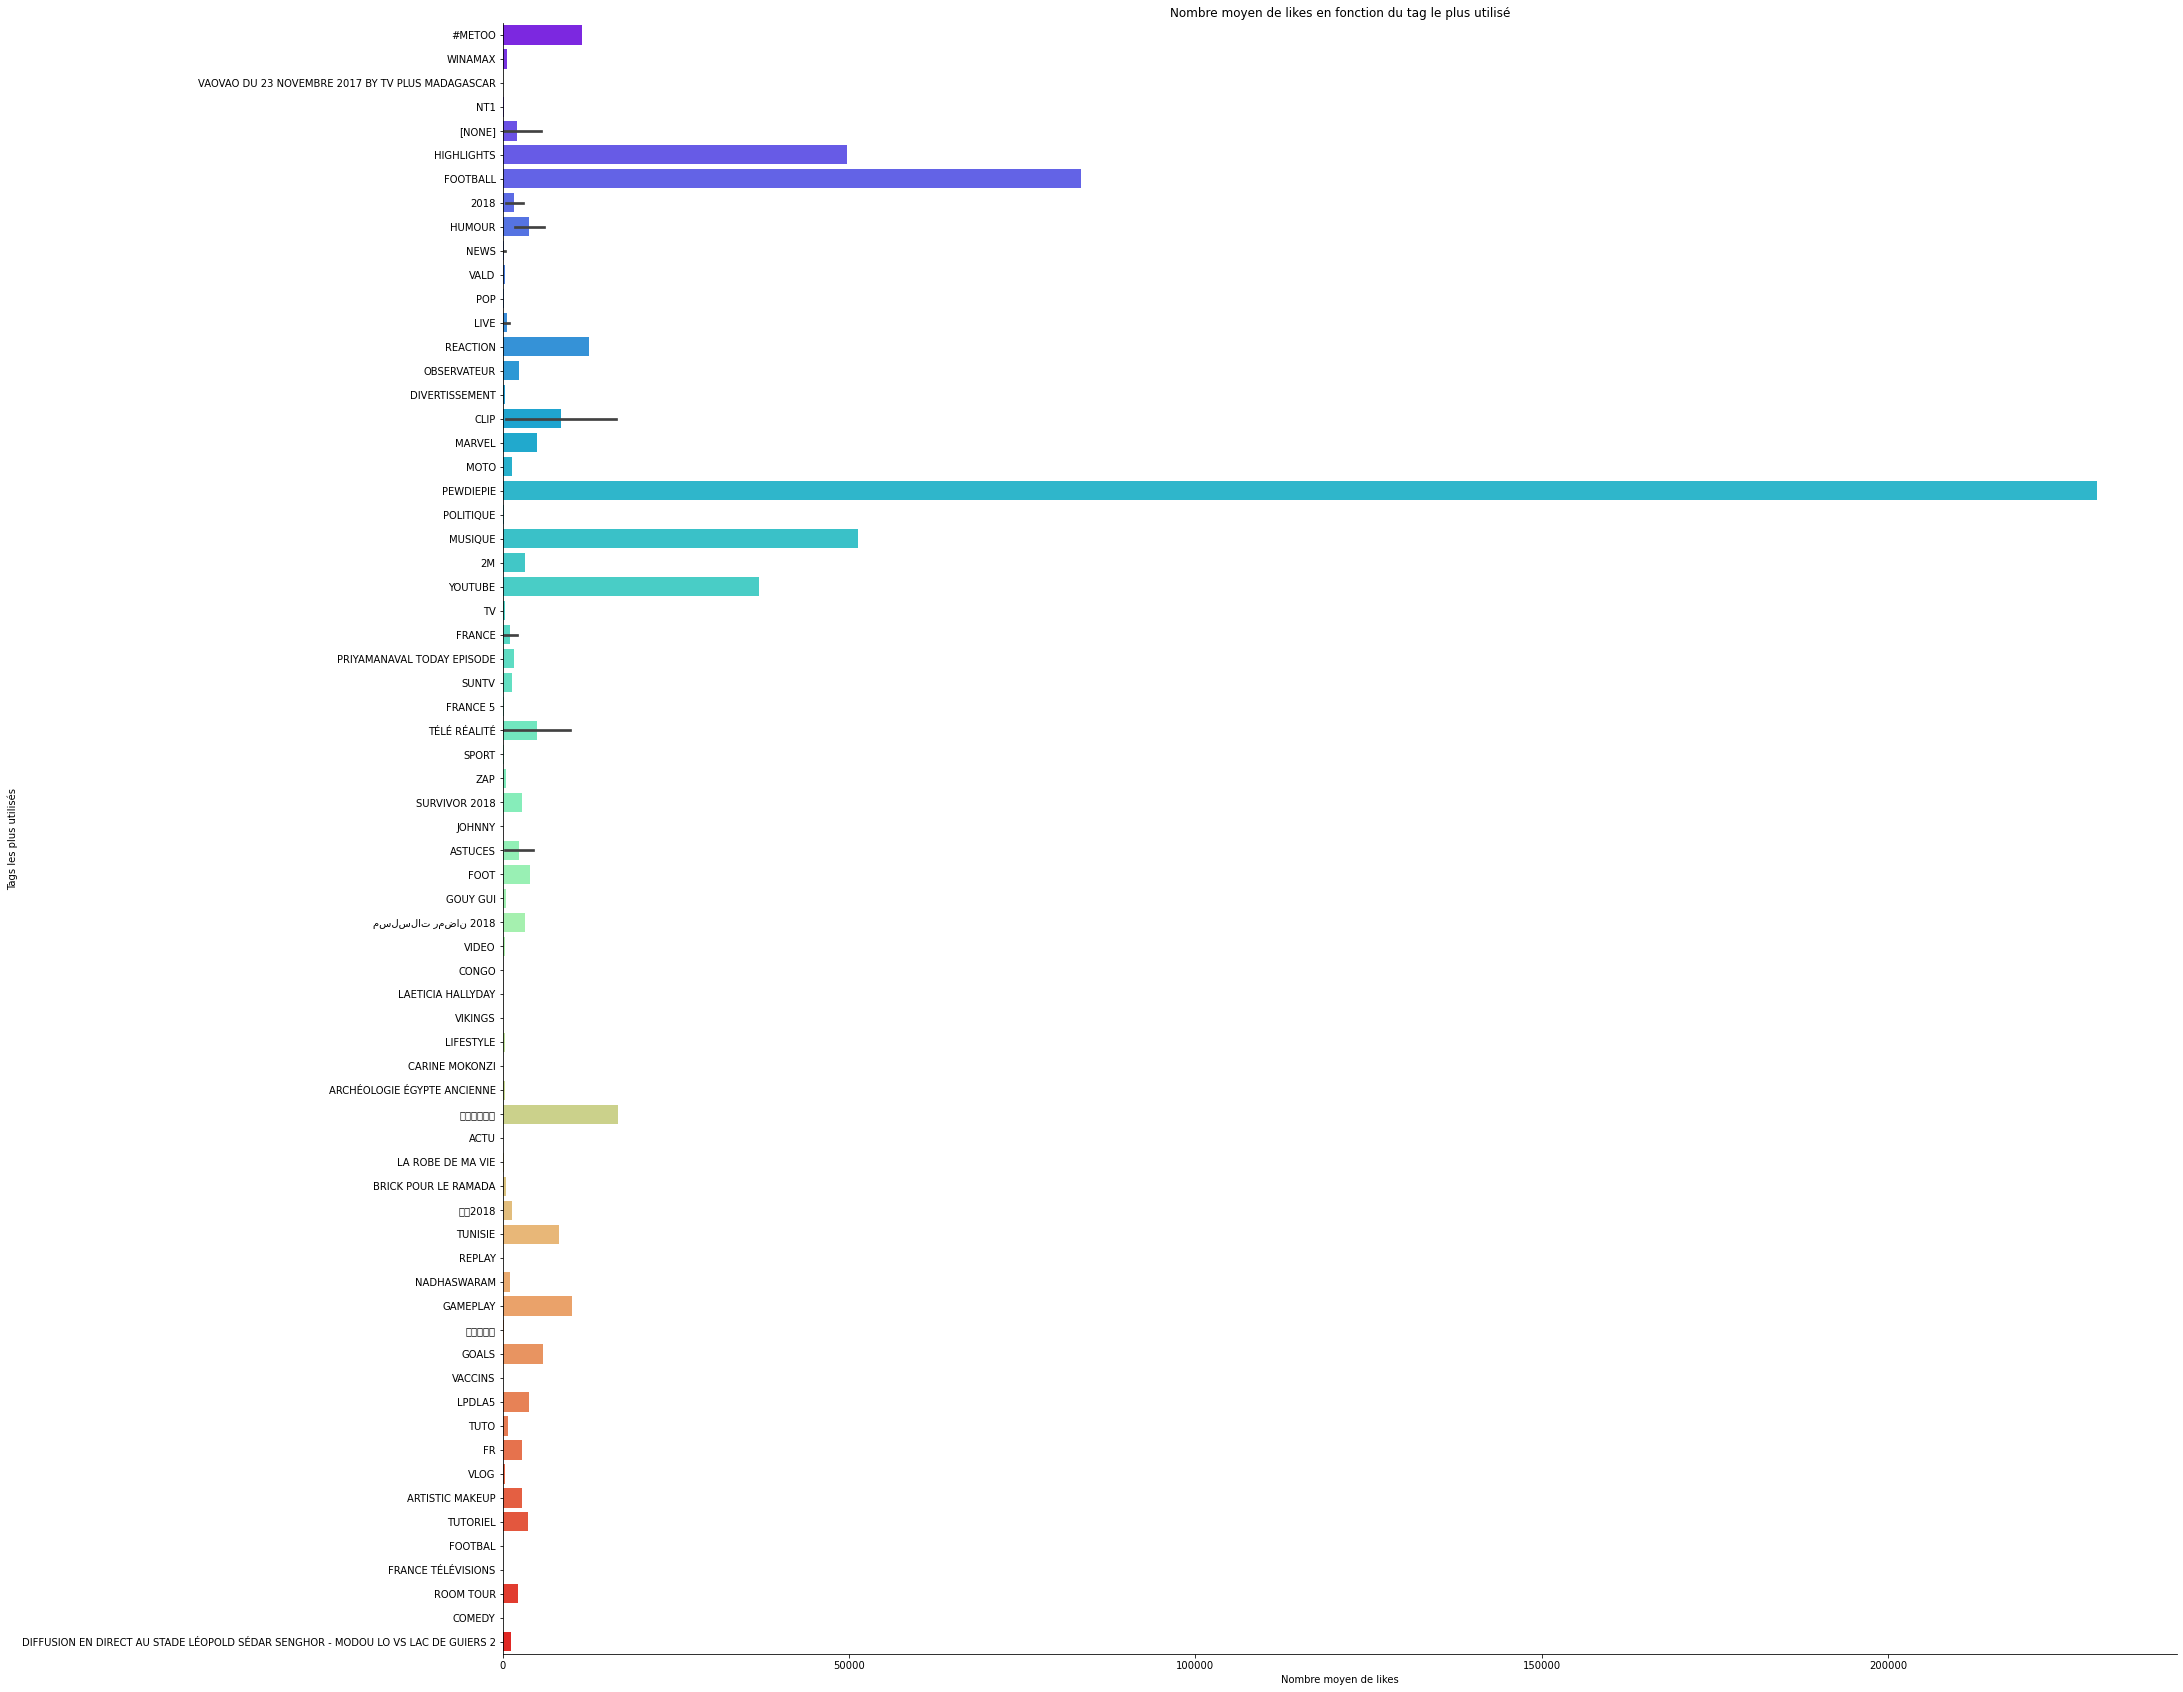

In [67]:
plt.figure(figsize=(30,30))

sns.barplot(data=df_fr.sample(100), x="likes", y="tags", estimator=np.mean ,palette="rainbow")

plt.title("Nombre moyen de likes en fonction du tag le plus utilisé")
plt.xlabel("Nombre moyen de likes")
plt.ylabel("Tags les plus utilisés")

sns.despine()
plt.show()

# Des Warnings peuvent apparaître, ils sont dus au fait que Python ne supporte pas certain des caractères utilisés, notamment les hanja coréens
# De plus, seules 100 vidéos sont sélectionnées car le graphe devient illisible autrement

In [39]:
df_fr[:25000].shape

(25000, 24)

In [40]:
X = df_fr[:25000].drop('likes', axis = 1)
y = df_fr[:25000].likes
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=36)

In [41]:
# Pipeline de preprocessing sur les données numériques (identique à ce qu'on a fait précédement)
numerical_features = ['views','dislikes','comment_count','category_id','nb_trend_days','publish_year','sin_publish_month','cos_publish_month','sin_publish_day','cos_publish_day','sin_publish_hour','cos_publish_hour','comments_disabled','ratings_disabled','video_error_or_removed']

numerical_preprocessing = Pipeline([('scaler', StandardScaler())])

# Pipeline de preprocessing sur les données catégorielles (le nom des chaînes des vidéos en tendance)
categorical_features = ['channel_title']

categorical_preprocessing = Pipeline([('encoding', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_preprocessing, categorical_features),
        ('numericals', numerical_preprocessing, numerical_features)
    ],
    remainder = 'drop'
)

# On peut maintenant créer notre pipeline avec le preprocessing et notre classifieur

pipeline = Pipeline([('preprocessor', preprocessor), ('clf', Ridge())])

params = [{'preprocessor__numericals__scaler': [StandardScaler(), 'passthrough'],
         'clf__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}]

# On peut enfin lancer les différents fits qui vont déterminer les meilleures variables de notre  problème

rskf = StratifiedKFold(n_splits=10, shuffle=False)
mc = GridSearchCV(pipeline, params, scoring = 'r2', cv = rskf, n_jobs = -1)

mc.fit(X_train, y_train)

print(f'Best parameter set: {mc.best_params_}\n')

preds = mc.predict(X_test)
print(f'R2-score: {r2_score(y_test, preds):.5f}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameter set: {'clf__alpha': 0.01, 'preprocessor__numericals__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

R2-score: 0.80437


In [46]:
#pour sauvegarder notre modèle grâce à joblib
import joblib
joblib.dump(mc,'youtube_likes.joblib')

['youtube_likes.joblib']

In [52]:
df_fr.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'nb_trend_days',
       'publish_year', 'sin_publish_month', 'cos_publish_month',
       'sin_publish_day', 'cos_publish_day', 'sin_publish_hour',
       'cos_publish_hour'],
      dtype='object')

On remarque qu'encore une fois notre score a augmenté après l'ajout de notre attribut tag.

In [53]:
export=df_fr[25000:]
export = export.drop('likes', axis = 1)

In [50]:
export.to_csv('fichier_test.csv')

In [51]:
print(export.shape)

(5578, 24)
